In [33]:
import google.generativeai as genai
from dotenv import load_dotenv
import os 
import pandas as pd
load_dotenv()
# YOUR API KEY
genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))

In [34]:
genai.configure(transport='grpc')

In [ ]:
!gcloud auth application-default login --client-id-file client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'

In [36]:
# Load the Excel file
excel_file = 'news_summary.xlsx' 
df = pd.read_excel(excel_file)
training_data = []
for index, row in df.head(600).iterrows():
    training_data.append({'text_input': str(row['ctext']), 'output': str(row['text'])})
    

In [37]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods][0]
    

In [38]:
name = 'news-summy'

In [39]:
operation = genai.create_tuned_model(
    source_model=base_model.name,
    training_data=training_data, 
    id=name,
    epoch_count=100,
    batch_size=10,
    learning_rate=1
)

In [40]:
model = genai.get_tuned_model(f'tunedModels/{name}')
model

TunedModel(name='tunedModels/news-summy',
           source_model='models/gemini-1.0-pro-001',
           base_model='models/gemini-1.0-pro-001',
           display_name='',
           description='',
           temperature=0.9,
           top_p=1.0,
           top_k=1,
           state=<State.CREATING: 1>,
           create_time=datetime.datetime(2024, 3, 8, 7, 44, 43, 553208, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 3, 8, 7, 44, 43, 553208, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2024, 3, 8, 7, 44, 44, 52083, tzinfo=datetime.timezone.utc),
                                  complete_time=None,
                                  snapshots=[],
                                  hyperparameters=Hyperparameters(epoch_count=100,
                                                                  batch_size=10,
                                                                  learning_rate=1.0)))

In [41]:
model.state

<State.CREATING: 1>

In [42]:
operation.metadata


tuned_model: "tunedModels/news-summy"
total_steps: 6000

In [43]:
#check progress
import time

for status in operation.wait_bar():
  time.sleep(30)

  0%|          | 0/6000 [00:00<?, ?it/s]

In [13]:
# LOSS CURVE

<Axes: xlabel='epoch', ylabel='mean_loss'>

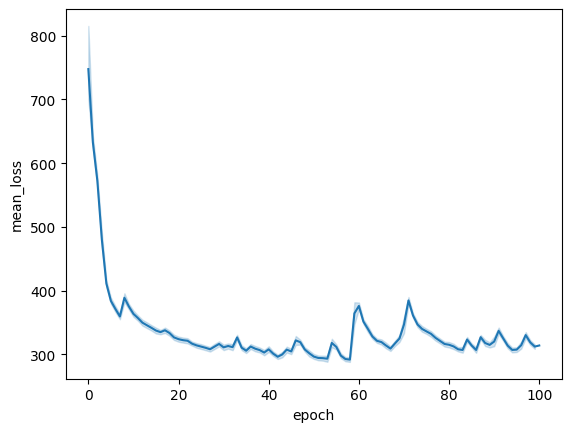

In [44]:
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')

In [53]:
#evaluate
safety_settings=[
  {
    "category": "HARM_CATEGORY_DANGEROUS",
    "threshold": "BLOCK_NONE",
  },
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_NONE",
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_NONE",
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_NONE",
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_NONE",
  },
]
generation_config  = {

    "temperature":0,
    "top_p" : 1,
    "top_k":1,
    "max_output_tokens":4000,
}
model = genai.GenerativeModel(model_name=f'tunedModels/{name}', generation_config=generation_config, safety_settings=safety_settings)


In [55]:
response = model.generate_content("""Slain Lashkar-e-Taiba (LeT) commander Abu Dujana will be replaced by Abu Ismail. Ismail will be the new Kashmir division chief of LeT after Dujana was killed by the security forces on Tuesday after a seven-hour gunfight in south Kashmir's Pulwama district. LeT commander Abu Ismail, a Pakistani national, was the mastermind of the deadly attack on Amarnath Yatra in which seven pilgrims, including six women, were killed and 19 were injured. Proactive operations have been launched, mainly in south Kashmir, to track down Ismail as investigations including communication intercepts have pointed out to his involvement in the attack on Amarnath pilgrims.Attack in Anantnag appears to be a reprisal for killing of several Lashkar militants including Bashir Lashkari in an encounter with security forces earlier this month. WHO WAS ABU DUJANA: (With inputs from Jitendra Bahadur Singh) Also read:Abu Dujana encounter: Jilted lover turned informer led security forces to LeT commander Top Lashkar-e-Taiba terrorist Abu Dujana killed in Pulwama encounter""")


In [56]:
response.text

'The Delhi High Court on Tuesday said that the government has been found in the country.'

In [57]:
response = model.generate_content('The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Daman and Diu administration a day apart. The circular was withdrawn through a one-line order issued late in the evening by the UT?s department of personnel and administrative reforms.?The circular is ridiculous. There are sensitivities involved. How can the government dictate who I should tie rakhi to? We should maintain the professionalism of a workplace? an official told Hindustan Times earlier in the day. She refused to be identified.The notice was issued on Daman and Diu administrator and former Gujarat home minister Praful Kodabhai Patel?s direction, sources said.Rakshabandhan, a celebration of the bond between brothers and sisters, is one of several Hindu festivities and rituals that are no longer confined of private, family affairs but have become tools to push politic al ideologies.In 2014, the year BJP stormed to power at the Centre, Rashtriya Swayamsevak Sangh (RSS) chief Mohan Bhagwat said the festival had ?national significance? and should be celebrated widely ?to protect Hindu culture and live by the values enshrined in it?. The RSS is the ideological parent of the ruling BJP.Last year, women ministers in the Modi government went to the border areas to celebrate the festival with soldiers. A year before, all cabinet ministers were asked to go to their constituencies for the festival.')
response.text

'The Delhi High Court on Monday said that the government has been found in the country.'